# Importing libraries

In [18]:
import os, re, string, warnings, sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

import nltk, re, string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud

sys.path.append(str(Path.cwd().parent / "src"))

from setup import Setup

# call the one method you need
setup = Setup()
setup.download_nltk_data()


# Reading the data

In [19]:
passages = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-wikipedia/data/passages.parquet/part.0.parquet")
passages.reset_index(inplace=True)
passages.rename(columns={"index": "id"}, inplace=True)
print(passages.shape)
passages.head()


(3200, 2)


,id,passage
0,0,"Uruguay (official full name in ; pron. , Eas..."
1,1,"It is bordered by Brazil to the north, by Arge..."
2,2,Montevideo was founded by the Spanish in the e...
3,3,The economy is largely based in agriculture (m...
4,4,"According to Transparency International, Urugu..."


In [20]:
passages.to_csv('/Users/ritvikhariharan/Desktop/Course Readings/NLX & LLM/rharihar_Assignment2-rag/data/passages.csv', index=False)


# Exploratory Data Analysis

In [21]:
passages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       3200 non-null   int64 
 1   passage  3200 non-null   string
dtypes: int64(1), string(1)
memory usage: 50.1 KB


In [22]:
passages.describe()

,id
count,3200.000000
mean,1600.283125
std,924.199020
min,0.000000
25%,800.750000
50%,1600.500000
75%,2400.250000
max,3200.000000


In [23]:
passages['passage'][0]

'Uruguay (official full name in  ; pron.  , Eastern Republic of  Uruguay) is a country located in the southeastern part of South America.  It is home to 3.3 million people, of which 1.7 million live in the capital Montevideo and its metropolitan area.'

In [24]:
passages['passage_len'] = passages['passage'].str.len()

# Basic stats
print("Passages shape:", passages.shape)
print("\nColumn names:", passages.columns.tolist())
print("\nMissing values:")
print(passages.isnull().sum())

print("\nPassage length (characters):")
print("Min:", passages['passage_len'].min())
print("Max:", passages['passage_len'].max())
print("Mean:", passages['passage_len'].mean())
print("Median:", passages['passage_len'].median())

Passages shape: (3200, 3)

Column names: ['id', 'passage', 'passage_len']

Missing values:
id             0
passage        0
passage_len    0
dtype: int64

Passage length (characters):
Min: 1
Max: 2515
Mean: 389.848125
Median: 299.0


In [25]:
print("\nShortest passage:\n", passages.loc[passages['passage_len'].idxmin(), 'passage'])
print("\nLongest passage:\n", passages.loc[passages['passage_len'].idxmax(), 'passage'])


Shortest passage:
 |

Longest passage:
 As Ford approached his ninetieth year, he began to experience significant health problems associated with old age. He suffered two minor strokes at the 2000 Republican National Convention, but made a quick recovery.  Gerald Ford recovering after strokes. BBC, August 2, 2000.  Retrieved on December 31, 2006.  In January 2006, he spent 11 days at the Eisenhower Medical Center near his residence at Rancho Mirage, California, for treatment of pneumonia.  Former President Ford, 92, hospitalized with pneumonia. Associated Press, January 17, 2006. Retrieved on October 19, 2007.  On April 23, President George W. Bush visited Ford at his home in Rancho Mirage for a little over an hour. This was Ford's last public appearance and produced the last known public photos, video footage and voice recording. While vacationing in Vail, Colorado, he was hospitalized for two days in July, 2006 for shortness of breath.  Gerald Ford released from hospital. Associated

In [26]:
passages['passage_word_count'] = passages['passage'].str.split().apply(len)
print("\nPassage length (words):")
print("Min:", passages['passage_word_count'].min())
print("Max:", passages['passage_word_count'].max())
print("Mean:", passages['passage_word_count'].mean())
print("Median:", passages['passage_word_count'].median())


Passage length (words):
Min: 1
Max: 425
Mean: 62.10375
Median: 48.0


In [27]:
print("\nShortest passage (words):\n", passages.loc[passages['passage_word_count'].idxmin(), 'passage'])
print("\nLongest passage (words):\n", passages.loc[passages['passage_word_count'].idxmax(), 'passage'])


Shortest passage (words):
 125px

Longest passage (words):
 As Ford approached his ninetieth year, he began to experience significant health problems associated with old age. He suffered two minor strokes at the 2000 Republican National Convention, but made a quick recovery.  Gerald Ford recovering after strokes. BBC, August 2, 2000.  Retrieved on December 31, 2006.  In January 2006, he spent 11 days at the Eisenhower Medical Center near his residence at Rancho Mirage, California, for treatment of pneumonia.  Former President Ford, 92, hospitalized with pneumonia. Associated Press, January 17, 2006. Retrieved on October 19, 2007.  On April 23, President George W. Bush visited Ford at his home in Rancho Mirage for a little over an hour. This was Ford's last public appearance and produced the last known public photos, video footage and voice recording. While vacationing in Vail, Colorado, he was hospitalized for two days in July, 2006 for shortness of breath.  Gerald Ford released from 

In [28]:
print(passages['passage'].duplicated().sum(), "duplicate passages found.")

4 duplicate passages found.


In [29]:
duplicate_passages = passages[passages['passage'].duplicated(keep=False)]
duplicate_passages.value_counts('passage')

passage
; Government                                                                                3
* Pratt, H., "Nikola Tesla 1856 1943", Proceedings of the IRE, Vol. 44, September, 1956.    2
|-                                                                                          2
Name: count, dtype: int64

In [30]:
STOP = set(stopwords.words("english"))
PUNCT = set(string.punctuation)
NUM_RE = re.compile(r"^\d+(\.\d+)?$")  # integers or decimals

def extract_top_words(text: str, k: int = 5):
    if not isinstance(text, str):
        return []
    # tokenize
    toks = word_tokenize(text)
    # normalize + filter
    toks = [
        t.lower()
        for t in toks
        if t.lower() not in STOP            # remove stopwords
        and t not in PUNCT                  # remove punctuation tokens
        and not NUM_RE.match(t)             # drop pure numbers
    ]
    if not toks:
        return []
    # rank by frequency (then alphabetically for stable ties)
    counts = Counter(toks)
    top = sorted(counts.items(), key=lambda x: (-x[1], x[0]))[:k]
    return [w for w, _ in top]

# Apply to your dataframe (expects columns: 'id', 'passage')
passages["top5_words"] = passages["passage"].apply(extract_top_words, k=5)
passages[['id', 'top5_words']].head(10)

,id,top5_words
0,0,"[million, uruguay, america, area, capital]"
1,1,"[french, south, across, america, argentina]"
2,2,"[head, 18th, argentina, brazil, century]"
3,3,"[economy, affected, agriculture, badly, based]"
4,4,"[according, america, among, chile, conditions]"
5,5,"[american, bay, became, civil, civil-union]"
6,6,"[population, --, catholics, cia, declared]"
7,7,"[meanings, '', ``, comes, guaranã­]"
8,8,"['', 'painted, ``, attributed, birds]"
9,9,"['', ``, anonymous, bring, discovery]"


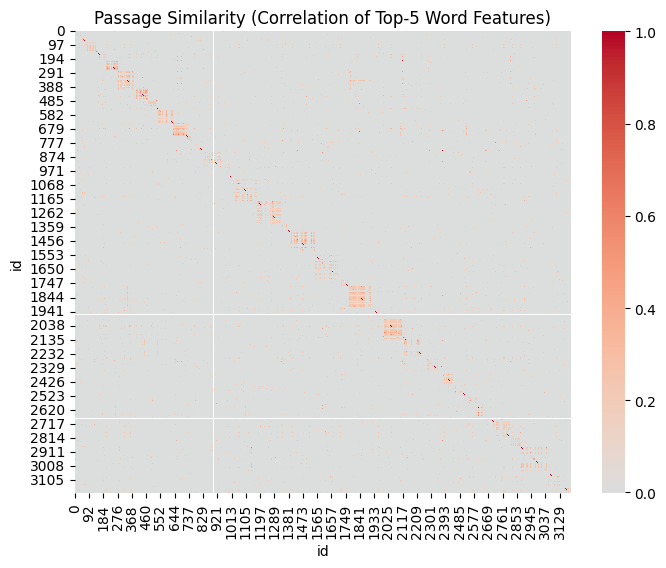

id,0,1,2,3,4,5,6,7,8,9,...,3191,3192,3193,3194,3195,3196,3197,3198,3199,3200
id,,,,,,,,,,,,,,,,,,,,,
0,1.0000,0.1992,-0.0010,-0.001,0.1992,-0.001,-0.000894,-0.000774,-0.000774,-0.000774,...,-0.000774,-0.000774,-0.000894,-0.001,-0.000894,-0.001,-0.001,-0.001,-0.001,-0.001
1,0.1992,1.0000,0.1992,-0.001,0.1992,-0.001,-0.000894,-0.000774,-0.000774,-0.000774,...,-0.000774,-0.000774,-0.000894,-0.001,-0.000894,-0.001,-0.001,-0.001,-0.001,-0.001
2,-0.0010,0.1992,1.0000,-0.001,-0.0010,-0.001,-0.000894,-0.000774,-0.000774,-0.000774,...,-0.000774,-0.000774,-0.000894,-0.001,-0.000894,-0.001,-0.001,-0.001,-0.001,-0.001
3,-0.0010,-0.0010,-0.0010,1.000,-0.0010,-0.001,-0.000894,-0.000774,-0.000774,-0.000774,...,-0.000774,-0.000774,-0.000894,-0.001,-0.000894,-0.001,-0.001,-0.001,-0.001,-0.001
4,0.1992,0.1992,-0.0010,-0.001,1.0000,-0.001,-0.000894,-0.000774,-0.000774,-0.000774,...,-0.000774,-0.000774,-0.000894,-0.001,-0.000894,-0.001,-0.001,-0.001,-0.001,-0.001


In [31]:
docs = passages["top5_words"].apply(lambda words: " ".join(words))

# Bag-of-words encoding: each word is a feature (0/1 or counts)
vectorizer = CountVectorizer(binary=True)  # presence/absence
X = vectorizer.fit_transform(docs)

# Build DataFrame with words as columns
df_features = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out(), index=passages["id"])

# Compute correlation matrix across passages
corr = df_features.T.corr()  # correlation between rows = passages

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False, cbar=True)
plt.title("Passage Similarity (Correlation of Top-5 Word Features)")
plt.show()

# Optional: inspect numeric correlation values
display(corr.head())

Top 15 words: [("''", 1054), ('``', 1047), ('also', 457), ('president', 444), ('one', 425), ('new', 414), ('first', 393), ('roosevelt', 363), ('world', 332), ('war', 332), ('lincoln', 314), ('tesla', 310), ('grant', 302), ('two', 277), ('states', 273)]


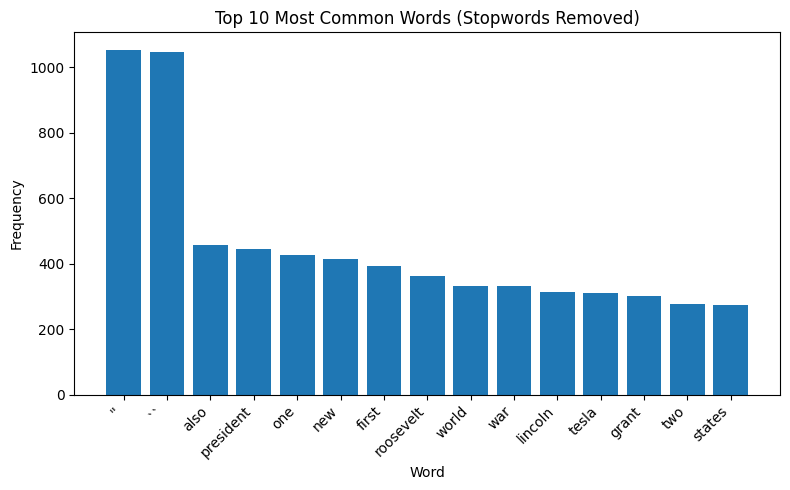

In [32]:
text = ' '.join(passages['passage'].tolist())
STOP = set(stopwords.words("english"))

tokens = word_tokenize(text)

# remove stopwords (+ optional: drop punctuation & numbers)
clean_tokens = [
    t for t in tokens
    if t.lower() not in STOP
    and t not in string.punctuation
    and not re.fullmatch(r"\d+(\.\d+)?", t)
    and t.lower() != "'s"
]

word_freq = Counter([t.lower() for t in clean_tokens])

# Get top 10 most common words
top15 = word_freq.most_common(15)
print("Top 15 words:", top15)

# Convert to two lists for plotting
words, counts = zip(*top15)

# Plot
plt.figure(figsize=(8,5))
plt.bar(words, counts)
plt.title("Top 10 Most Common Words (Stopwords Removed)")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

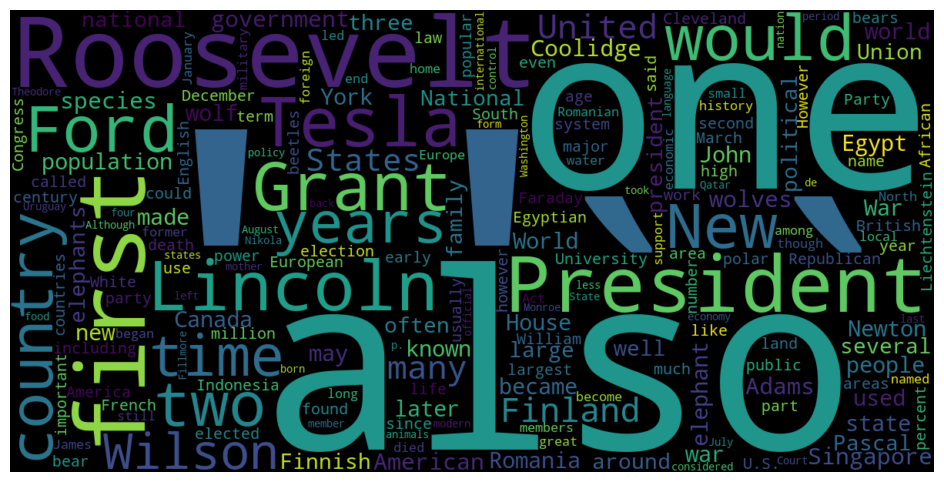

In [33]:
freqs = Counter(clean_tokens)  # dict of token -> count
wc = WordCloud(width=1200, height=600, collocations=False).generate_from_frequencies(freqs)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()